# Sentiment Analysis using deep learning models RNN


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN, LSTM, GRU, Dense, SpatialDropout1D, Bidirectional,Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)


2024-07-13 09:57:43.261330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 09:57:43.261443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 09:57:43.362808: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Using multiple GPUs (optional)
The best practice for using multiple GPUs is to use tf.distribute.Strategy
[https://www.tensorflow.org/guide/gpu#using_multiple_gpus](http://)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2 Physical GPU, 3 Logical GPUs


In [3]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(1,))
  predictions = tf.keras.layers.Dense(1)(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

**Load Train Data**

In [4]:
# Load your dataset
df = pd.read_csv('/kaggle/input/train-data/aclImdb_data_50000.csv')  # Ensure your dataset has 'text' and 'label' columns
df.head(5)

,text,label
0,In a college dorm a guy is killed by somebody ...,neg
1,The production year says it all. The movie is ...,neg
2,A pleasant surprise! I expected a further down...,pos
3,"The ""math"" aspect to this is merely a gimmick ...",neg
4,Some of the greatest and most loved horror mov...,neg


In [5]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # Assuming 'Positive' and 'Negative' are converted to 1 and 0
df

,text,label
0,In a college dorm a guy is killed by somebody ...,0
1,The production year says it all. The movie is ...,0
2,A pleasant surprise! I expected a further down...,1
3,"The ""math"" aspect to this is merely a gimmick ...",0
4,Some of the greatest and most loved horror mov...,0
...,...,...
49995,I found this gem in a rack the local video ren...,0
49996,If we consider three films with a similar subj...,1
49997,King of Masks (Bian Lian in China) is a shocki...,1
49998,It's hard to know what was going through Per K...,0


In [6]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'neg': 0, 'pos': 1}


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)      

(40000,) (40000,)
(10000,) (10000,)


In [8]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000, lower=True, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_seq_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

**MODEL**

In [9]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_seq_length))
    model.add(SpatialDropout1D(0.5))  # Increase dropout rate
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))  # Add Dropout layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [10]:
# Choose the model you want to train and evaluate
model = create_lstm_model()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Training**

In [11]:

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience = 3, 
                                        restore_best_weights=True)

import time 
start_time = time.time() # Start time

# Train the model
history = model.fit(X_train_pad, y_train, epochs=50, batch_size=64, validation_data=(X_test_pad, y_test),
          verbose=1,callbacks=[early_stopping_callback])#callbacks=[early_stopping_callback]
end_time = time.time()# End time
# Calculate elapsed time
elapsed_time = (end_time - start_time) / 60
print(f"Training time: {elapsed_time:.2f} minutes")
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7188 - loss: 0.5177 - val_accuracy: 0.8635 - val_loss: 0.3170
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8674 - loss: 0.3114 - val_accuracy: 0.8579 - val_loss: 0.3221
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8897 - loss: 0.2715 - val_accuracy: 0.8636 - val_loss: 0.3215
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8991 - loss: 0.2440 - val_accuracy: 0.8639 - val_loss: 0.3148
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9121 - loss: 0.2183 - val_accuracy: 0.8656 - val_loss: 0.3277
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9238 - loss: 0.1968 - val_accuracy: 0.8615 - val_loss: 0.3420
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9319 - loss: 0.1766 - val_accuracy: 0.8566 - val_loss: 0.3446
Training time: 0.63 minutes
Accuracy: 86.39%


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 128)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (64, 100, 128)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 128)              │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,315,141 (8.83 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,543,428 (5.89 MB)

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


***loss function curve***

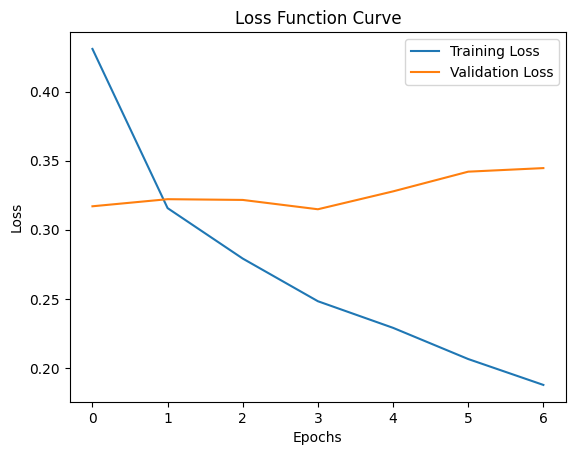

In [14]:
# Plotting the loss function curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


[[4375  620]
 [ 741 4264]]


In [17]:
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

         neg       0.86      0.88      0.87      4995
         pos       0.87      0.85      0.86      5005

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



> In conclusion, the model shows balanced performance across both classes with similar precision, recall, and F1-scores, resulting in an overall accuracy of 86%.








##  **Save model file**

In [18]:
# Save the entire model to a file
model.save('./sentiment_analysis_LSTM_model.h5')

In [19]:
import pickle

# Save the tokenizer
with open('./tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
